In [1]:
import sys
from scipy.sparse import csr_matrix
import numpy as np
from Eval import Eval
from math import log, exp
import time
from imdb import IMDBdata
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

In [2]:
class Eval:
    def __init__(self, pred, gold):
        self.pred = pred
        self.gold = gold
        #create a confusion matrix
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0

    def Accuracy(self):
        return np.sum(np.equal(self.pred, self.gold)) / float(len(self.gold))

    def Precision(self):
        return self.tp / (self.tp + self.fp)

    def Recall(self):
        return self.tp / (self.tp + self.fn)

    def ComputeConfusionMatrix(self):
        for pred, label in zip(self.pred, self.gold):
            if pred + label == 2:
                self.tp += 1
            elif(pred + label) == -2:
                self.tn += 1
            elif pred > label:
                self.fp += 1
            else:
                self.fn += 1

In [19]:
class NaiveBayes:
    def __init__(self, data, ALPHA=1.0):
        #Initialization of each instance variables by the type they need.
        self.ALPHA = ALPHA
        self.data = data
        self.vocab_len = 0
        self.num_positive_reviews = 0
        self.num_negative_reviews = 0
        self.total_number_of_reviews = 0
        self.count_positive = defaultdict(int)
        self.count_negative = defaultdict(int)
        self.total_positive_words = 0
        self.total_negative_words = 0
        self.total_positive_term = 0
        self.total_negative_term = 0
        self.P_positive = defaultdict(float)
        self.P_negative = defaultdict(float)
        self.deno_pos = 0
        self.deno_neg = 0

        print("Training the model ...")
        self.Train(data.X,data.Y)

    # Train model - X are instances, Y are labels (+1 or -1)
    # X and Y are sparse matrices
    def Train(self, X, Y):
        #Estimation of the Naive Bayes model parameters

        #Getting the number of unique word in the training corpus
        self.vocab_len = X.shape[1]
        
        #Getting the number of positive and negative reviews based on the label of the training set.
       
        #Positive reviews
        self.num_positive_reviews = np.count_nonzero(Y == 1)
        #Negative reviews
        self.num_negative_reviews = np.count_nonzero(Y == -1)

        #Getting the total number of reviews in the training data set.
        self.total_number_of_reviews = X.shape[0]

        #Count number of word occurences in the corpus for positive and negative reviews and create a dictionnay
        #from it.
        for review in range(self.total_number_of_reviews):
            for word, occurences in zip(X[review].indices, X[review].data):
                if traindata.Y[review] == 1:
                    self.count_positive[word] += occurences
                elif traindata.Y[review] == -1:
                    self.count_negative[word] += occurences

        # Represent the sum of each occurences for each word in class label
        self.total_positive_words = sum(self.count_positive.values())
        self.total_negative_words = sum(self.count_negative.values())
        
        # Represent number of unique words in each label
        self.total_positive_term = len(self.count_positive.keys())
        self.total_negative_term = len(self.count_negative.keys())

        # Denominator number for the computation of P(W|C). C is + or -
        #self.deno_pos = self.vocab_len * self.ALPHA + self.total_positive_words 
        #self.deno_neg = self.vocab_len * self.ALPHA + self.total_negative_words 
        self.deno_pos = self.vocab_len + self.total_positive_words
        self.deno_neg = self.vocab_len + self.total_negative_words

        # Compute probabilities for each term inside a concept P(W|C) using log in order to avoid
        # future underflow
        for word in range(self.vocab_len):
            self.P_positive[word] = log((self.count_positive[word] + self.ALPHA) / self.deno_pos)
        for word in range(self.vocab_len):
            self.P_negative[word] = log((self.count_negative[word] + self.ALPHA) / self.deno_pos)        

    def LogSum(self, logx, logy):
        return logx + logy


    # Predict labels for instances X
    # Return: Sparse matrix Y with predicted labels (+1 or -1)
    def PredictLabel(self, X):
        # Naive Bayes Classification
        
        pred_labels = []
        score_word_pos = 1
        score_word_neg = 1
        number_of_training_reviews = X.shape[0]

        for review in range(number_of_training_reviews):

            # Compute the probability of each concept P(C) C is equal to + or - 
            score_word_pos = log(self.num_positive_reviews/ self.total_number_of_reviews)
            score_word_neg = log(self.num_negative_reviews/ self.total_number_of_reviews)

            # Compute the probability that each review belongs to a specific class label 
            for word, occurences in zip(X[review].indices, X[review].data):
                # For positive class
                score_word_pos = self.LogSum(score_word_pos, self.P_positive[word]*occurences)
                # For negative class
                score_word_neg = self.LogSum(score_word_neg, self.P_negative[word]*occurences)

            # Predict the label of the review.
            if score_word_pos > score_word_neg: 
            # Predict positive
                pred_labels.append(1.0)
            else:
            # Predict negative
                pred_labels.append(-1.0)

        return pred_labels


    # Predict the probability of each indexed review in sparse matrix text
    # of being positive
    # Prints results
    def PredictProb(self, test, indexes):

        number_positive_reviews = 0
        number_negative_reviews = 0
        predicted_label = 0
        positive_probs = []
        precision_recall_points = []
        # Compute the number of positives and negatives reviews in the dataset. 
        for review in indexes:
            if test.Y[review] == 1:
                number_positive_reviews += 1
            if test.Y[review] == -1:
                number_negative_reviews += 1

        for review in indexes:

            # Compute the probability of each concept P(C) C is equal to + or - 
            predicted_prob_positive = log(number_positive_reviews/ len(indexes))
            predicted_prob_negative = log(number_negative_reviews/ len(indexes))

            # Compute the probability that each review belongs to a specific class label 
            for word, occurences in zip(test.X[review].indices, test.X[review].data):

                # For positive class
                predicted_prob_positive = self.LogSum(predicted_prob_positive, self.P_positive[word]*occurences)

                # For negative class
                predicted_prob_negative = self.LogSum(predicted_prob_negative, self.P_negative[word]*occurences)
            print(predicted_prob_positive, predicted_prob_negative)
            #Normalize probabilities
            final_predicted_prob_positive = ((1/predicted_prob_positive) / (1/(predicted_prob_positive) + 1/(predicted_prob_negative)))
            final_predicted_prob_negative = ((1/predicted_prob_negative) / (1/(predicted_prob_positive) + 1/(predicted_prob_negative)))

            positive_probs.append(final_predicted_prob_positive)
            if final_predicted_prob_positive > final_predicted_prob_negative:
                predicted_label = 1.0
            else:
                predicted_label = -1.0
            print(review, ":" ,test.Y[review], predicted_label, final_predicted_prob_positive, final_predicted_prob_negative)
            #print(test.Y[review], predicted_label, final_predicted_prob_positive, final_predicted_prob_negative, test.X_reviews[review])

        #Compute the Precision and Recall based on a threshold
        prediction_based_on_threshold = []
        for threshold in np.arange(0.49, 0.51, 0.01):
            for prob in positive_probs:
                if positive_probs[prob] > threshold :
                    prediction_based_on_threshold.append(1) 
                else :
                    prediction_based_on_threshold.append(-1) 
            ev = Eval(prediction_based_on_threshold, test.Y)
            ev.ComputeConfusionMatrix()
            precision_recall_points.append((ev.Precision(), ev.Recall()))
        print(precision_recall_points)
    
    def FeaturesSelection(self, vocab):
        word_neg = defaultdict(float)
        word_pos = defaultdict(float)
        for word in self.P_positive:
            word_neg[vocab.GetWord(word)] = (self.P_negative[word] - self.P_positive[word])# * (self.count_negative[word] + self.count_positive[word]
            word_pos[vocab.GetWord(word)] = (self.P_positive[word] - self.P_negative[word])# * (self.count_positive[word] + self.count_negative[word]
        word_neg = sorted(word_neg.items(), key=lambda x: x[1], reverse=True)
        word_pos = sorted(word_pos.items(), key=lambda x: x[1], reverse=True)
        
        print("TOP 20 Negative Words: \n", word_neg[:20])
        print("TOP 20 Positive Words: \n", word_pos[:20])

    # Evaluate performance on test data 
    def Eval(self, test):
        print("Predicting test reviews labels ...")
        Y_pred = self.PredictLabel(test.X)
        print("Evaluate the NaiveBayes model ...")
        ev = Eval(Y_pred, test.Y)
        return ev.Accuracy()

In [4]:
print("Reading Training Data")
traindata = IMDBdata("%s/train" % "data/aclImdb")
print("Reading Test Data")
testdata  = IMDBdata("%s/test" % "data/aclImdb", vocab=traindata.vocab)    
nb = NaiveBayes(traindata, float(1.0))
#print("Computing Parameters")
#print("Evaluating")
#print("Test Accuracy: ", nb.Eval(testdata))

Reading Training Data
Reading Test Data
Training the model ...


In [20]:
nb = NaiveBayes(traindata, float(1.0))
nb.FeaturesSelection(traindata.vocab)

Training the model ...
TOP 20 Negative Words: 
 [('/>4/10', 4.043051267834551), ('seagal', 4.034240638152395), ('2/10', 3.891820298110627), ('boll', 3.8815637979434374), ('uwe', 3.8712010109078907), ('*1/2', 3.828641396489095), ('unwatchable.', 3.8066624897703196), ('thunderbirds', 3.737669618283368), ('/>3/10', 3.713572066704309), ('gamera', 3.713572066704309), ('4/10', 3.6506582412937387), ('wayans', 3.610917912644224), ('awful!', 3.555348061489413), ('/>avoid', 3.465735902799727), ('slater', 3.465735902799727), ('tashan', 3.433987204485147), ('segal', 3.433987204485147), ('drivel.', 3.433987204485147), ('kareena', 3.401197381662156), ('aztec', 3.401197381662156)]
TOP 20 Positive Words: 
 [('edie', 4.418840607796598), ('gundam', 4.343805421853684), ('antwone', 4.127134385045093), ('/>8/10', 3.8712010109078907), ('yokai', 3.8712010109078907), ('/>7/10', 3.8501476017100593), ('gunga', 3.8501476017100593), ('/>10/10', 3.828641396489095), ('din', 3.8066624897703196), ('gypo', 3.806662489

In [123]:
def PredictProb(test, indexes):

    number_positive_reviews = 0
    number_negative_reviews = 0
    predicted_label = 0
    positive_probs = []
    negative_probs = []
    positive_precision_recall_points = []
    negative_precision_recall_points = []
    # Compute the number of positives and negatives reviews in the dataset. 
    for review in indexes:
        if test.Y[review] == 1:
            number_positive_reviews += 1
        if test.Y[review] == -1:
            number_negative_reviews += 1

    for review in indexes:

        # Compute the probability of each concept P(C) C is equal to + or - 
        predicted_prob_positive = log(number_positive_reviews/ len(indexes))
        predicted_prob_negative = log(number_negative_reviews/ len(indexes))

        # Compute the probability that each review belongs to a specific class label 
        for word, occurences in zip(test.X[review].indices, test.X[review].data):

            # For positive class
            predicted_prob_positive = LogSum(predicted_prob_positive, P_positive[word]*occurences)

            # For negative class
            predicted_prob_negative = LogSum(predicted_prob_negative, P_negative[word]*occurences)
        #Normalize probabilities
        final_predicted_prob_positive = ((1/predicted_prob_positive) / (1/(predicted_prob_positive) + 1/(predicted_prob_negative)))
        final_predicted_prob_negative = ((1/predicted_prob_negative) / (1/(predicted_prob_positive) + 1/(predicted_prob_negative)))

        positive_probs.append(final_predicted_prob_positive)
        negative_probs.append(final_predicted_prob_negative)
        if final_predicted_prob_positive > final_predicted_prob_negative:
            predicted_label = 1.0
        else:
            predicted_label = -1.0
        #print(review, ":" ,test.Y[review], predicted_label, final_predicted_prob_positive, final_predicted_prob_negative)
        #print(test.Y[review], predicted_label, final_predicted_prob_positive, final_predicted_prob_negative, test.X_reviews[review])

    #Compute the Precision and Recall based on a threshold
    for threshold in np.arange(0.49, 0.5099, 0.001):
        positive_prediction_based_on_threshold = []
        negative_prediction_based_on_threshold = []
        for prob in range(len(indexes)):
            if positive_probs[prob] > threshold :
                positive_prediction_based_on_threshold.append(1) 
            else :
                positive_prediction_based_on_threshold.append(-1)
        ev = Eval(positive_prediction_based_on_threshold, test.Y)
        ev.ComputeConfusionMatrix()
        positive_precision_recall_points.append((ev.Recall(), ev.Precision()))

        for prob in range(len(indexes)):
            if negative_probs[prob] > threshold :
                negative_prediction_based_on_threshold.append(1) 
            else :
                negative_prediction_based_on_threshold.append(-1)
        ev = Eval(negative_prediction_based_on_threshold, test.Y)
        ev.ComputeConfusionMatrix()
        negative_precision_recall_points.append((ev.Recall(), ev.Precision()))
    fig, ax = plt.subplots()
    ax.plot(*zip(*positive_precision_recall_points), *zip(*negative_precision_recall_points))
    plt.title('Precision versus Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


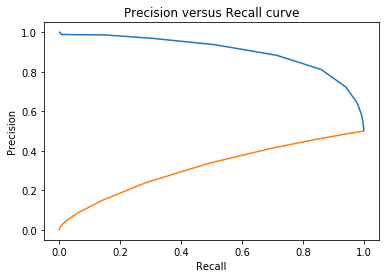

In [124]:
PredictProb(testdata, range(0,25000))